# CMPS-320 Homework #5
## Decision Tree Practice
Elijah Campbell-Ihim

12/1/23

## Import Libraries and data

In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import warnings
warnings.filterwarnings('ignore')


%matplotlib inline
plt.style.use('seaborn-v0_8-white')

In [4]:
#Import Data
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)

## Split the data into training, validation, and test sets (5:1:1 ratio)

In [5]:
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(
    mnist.data, mnist.target, test_size=0.2, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.125, random_state=42
)


## Train Random Forest, Bagging, and Decision Tree Classifiers

In [6]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# a. Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
rf_val_preds = rf_classifier.predict(X_val)
rf_accuracy = accuracy_score(y_val, rf_val_preds)

# b. Bagging classifier
bagging_classifier = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100, random_state=42)
bagging_classifier.fit(X_train, y_train)
bagging_val_preds = bagging_classifier.predict(X_val)
bagging_accuracy = accuracy_score(y_val, bagging_val_preds)

# c. Decision tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)
dt_val_preds = dt_classifier.predict(X_val)
dt_accuracy = accuracy_score(y_val, dt_val_preds)


## Obtain top 10 feature importances

In [7]:
# For Decision Tree
dt_feature_importances = dt_classifier.feature_importances_
dt_top_ten_indices = dt_feature_importances.argsort()[-10:][::-1]

# For Random Forest
rf_feature_importances = rf_classifier.feature_importances_
rf_top_ten_indices = rf_feature_importances.argsort()[-10:][::-1]


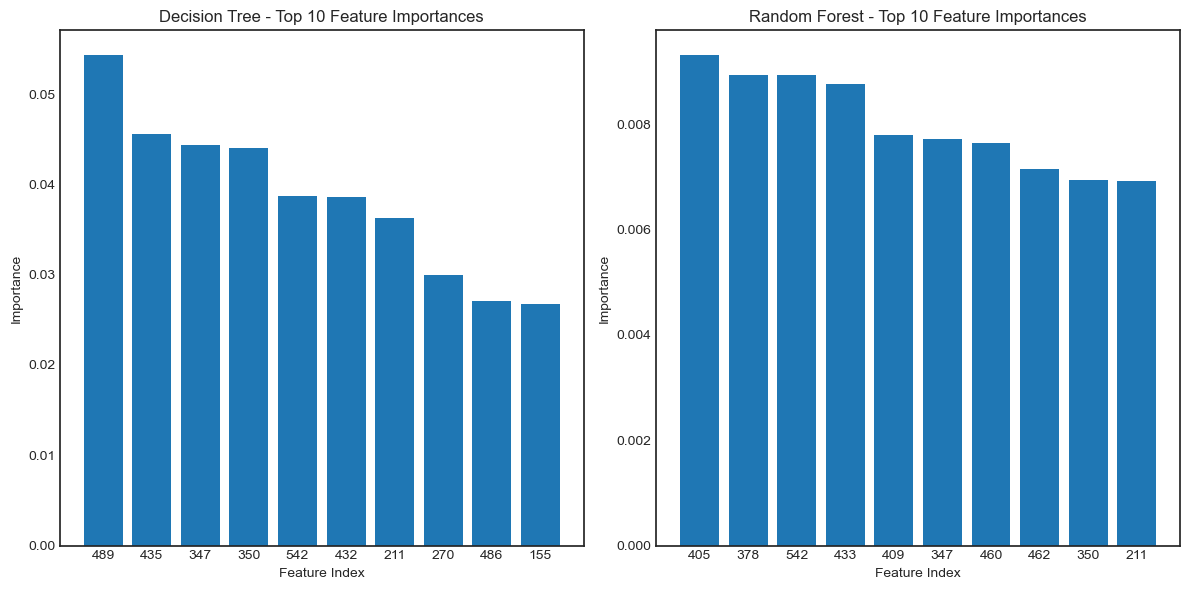

In [13]:
# Plotting for Decision Tree
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(range(len(dt_top_ten_indices)), dt_feature_importances[dt_top_ten_indices], align="center")
plt.xticks(range(len(dt_top_ten_indices)), dt_top_ten_indices)
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.title("Decision Tree - Top 10 Feature Importances")

# Plotting for Random Forest
plt.subplot(1, 2, 2)
plt.bar(range(len(rf_top_ten_indices)), rf_feature_importances[rf_top_ten_indices], align="center")
plt.xticks(range(len(rf_top_ten_indices)), rf_top_ten_indices)
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.title("Random Forest - Top 10 Feature Importances")

plt.tight_layout()
plt.show()

#### The feature importances give us information about which pixels contribute the most to the model's decision-making process when identifying handwritten digits. These are the indexes of the pixels in the data matrix that contribute most to our model's predictions

## Combine Classifiers into an ensemble

In [8]:
from sklearn.ensemble import VotingClassifier

ensemble_classifier = VotingClassifier(
    estimators=[('rf', rf_classifier), ('bagging', bagging_classifier), ('dt', dt_classifier)],
    voting='hard'
)

ensemble_classifier.fit(X_train, y_train)
ensemble_val_preds = ensemble_classifier.predict(X_val)
ensemble_accuracy = accuracy_score(y_val, ensemble_val_preds)


In [9]:
print("Random Forest Accuracy:", rf_accuracy)
print("Bagging Classifier Accuracy:", bagging_accuracy)
print("Decision Tree Accuracy:", dt_accuracy)
print("Ensemble Accuracy:", ensemble_accuracy)

Random Forest Accuracy: 0.9651428571428572
Bagging Classifier Accuracy: 0.9587142857142857
Decision Tree Accuracy: 0.865
Ensemble Accuracy: 0.9612857142857143


## Remove Weakest Classifier

In [10]:
classifiers = [rf_classifier, bagging_classifier, dt_classifier]
weakest_classifier = min(classifiers, key=lambda clf: accuracy_score(y_val, clf.predict(X_val)))
classifiers.remove(weakest_classifier)

# Ensemble without the weakest classifier
updated_ensemble_classifier = VotingClassifier(
    estimators=[('rf', classifiers[0]), ('bagging', classifiers[1])],
    voting='hard'
)

updated_ensemble_classifier.fit(X_train, y_train)
updated_ensemble_val_preds = updated_ensemble_classifier.predict(X_val)
updated_ensemble_accuracy = accuracy_score(y_val, updated_ensemble_val_preds)


In [21]:
print("Updated Ensemble Val Set Accuracy:", updated_ensemble_accuracy)

Updated Ensemble Val Set Accuracy: 0.9622857142857143


In [22]:
print("Random Forest Test Set Accuracy:", accuracy_score(y_test, rf_classifier.predict(X_test)))
print("Bagging Classifier Test Set Accuracy:", accuracy_score(y_test, bagging_classifier.predict(X_test)))
print("Decision Tree Test Set Accuracy:", accuracy_score(y_test, dt_classifier.predict(X_test)))
print("Updated Ensemble Test Set Accuracy:", accuracy_score(y_test, updated_ensemble_classifier.predict(X_test)))

Random Forest Test Set Accuracy: 0.9657857142857142
Bagging Classifier Test Set Accuracy: 0.9579285714285715
Decision Tree Test Set Accuracy: 0.8693571428571428
Updated Ensemble Test Set Accuracy: 0.9616428571428571


## Conclusion
It appears that the Random Forest Classifer is the best model. This is suprising, as the Ensemble had the benefits of all the classifiers combined, and it was expected to come out as the best model with the highest accuracy. However, Random Forest consistently beats out the Ensemble model, even after removing the weakest classifier. Although the Ensemble model did improve slightly (by .001) from the removal of the weakest classifier (decision tree in this case), it wasn't enough to beat the Random Forest Model, both in the validation set and the test set accuracy evaluations. 